Цель работы - реализация состязательного автокодировщика. Для этого необходимо регуляризацию латентного слоя осуществить с помощья сети-дискриминатора, вместо KL-divergence.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from utils import mnist, plot_graphs, plot_mnist

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

Результаты с использованием бинарной кросс-энтропии как функции ошибки реконструкции получились качественнее, чем при использовании mse. Поэтому датасет оставлен в виде интервала [0, 1].

In [0]:
mnist_0_1 = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
param_input_shape = 28*28
param_layers_size = (1024, 1024)
param_ld_size = 2
param_num_classes = 10
param_ae_loss_fn = F.binary_cross_entropy
param_batch_size = 250

In [0]:
train_loader, valid_loader, test_loader = mnist(batch_size=param_batch_size, valid=10000, transform=mnist_0_1)

In [0]:
class Encoder(nn.Module):
    # Переводит вход в латентный слой. Здесь теперь не нужны мю и сигма, достаточно z.
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(param_input_shape, param_layers_size[0])        
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])        
        self.z = nn.Linear(param_layers_size[1], param_ld_size)        
    
    def forward(self, x):
        x = x.view(-1, param_input_shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        z = self.z(x)        
        return z

class Decoder(nn.Module):
    # Восстанавливает изображение из z. На выходе сигмоид для [0, 1].
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(param_ld_size, param_layers_size[0])        
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])        
        self.fc3 = nn.Linear(param_layers_size[1], param_input_shape)
    
    def forward(self, x):        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class Discriminator(nn.Module):
    # Отличает сэмпл z от сэмпла N(0, 1), для регуляризации кодировщика.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(param_ld_size, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(param_layers_size[1], 1)

    def forward(self, x):
        x = torch.relu(self.do1(self.fc1(x)))
        x = torch.relu(self.do2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [0]:
E = Encoder()
E_opt = optim.Adam(E.parameters(), lr=1e-4)
E.to(device)

D = Decoder()
D_opt = optim.Adam(D.parameters(), lr=1e-4)
D.to(device)

DC = Discriminator()
DC_opt = optim.Adam(DC.parameters(), lr=1e-3)
DC.to(device)

train_log = {'AE': [], 'E': [], "DC": []}
test_log = {'AE': [], 'E': [], "DC": []}

In [0]:
batch_zeros = torch.zeros((param_batch_size, 1)).to(device)
batch_ones = torch.ones((param_batch_size, 1)).to(device)
# Многомерное нормальное распределение (для истинных сэмплов).
distribution = torch.distributions.MultivariateNormal(torch.zeros(param_ld_size), torch.eye(param_ld_size))

In [0]:
def train(epoch, E, D, DC, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):        
        data = data.to(device)
        target = target.to(device)

        # Обучение дискриминатора отличать истинное N(0, 1) от выхода кодировщика.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()
        
        fake_z = DC(E(data))
        true_z = DC(distribution.sample((param_batch_size, )).to(device))
        fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones)

        DC_loss = 0.5*(fake_loss + true_loss)
        DC_loss.backward()
        DC_opt.step()

        # Обучение автокодировщика.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()
        z = E(data)
        recon = D(z)
        reconstruction_loss = param_ae_loss_fn(recon, data.view(-1, param_input_shape))

        fake_z = DC(z)
        regularization_loss = F.binary_cross_entropy_with_logits(fake_z, batch_ones)

        AE_loss = reconstruction_loss + regularization_loss

        AE_loss.backward()
        D_opt.step()
        E_opt.step()
        
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'AE: {:.4f}, E: {:.4f}, DC: {:.4f}'.format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
            print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'AE: {:.4f}, E: {:.4f}, DC:{:.4f}'.format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
        print(line + losses)
        log['AE'].append(reconstruction_loss.item())
        log['E'].append(regularization_loss.item())
        log['DC'].append(DC_loss.item())

In [0]:
def test(E, D, DC, loader, epoch, log=None):
    test_size = len(loader)
    reconstruction_loss = 0.
    regularization_loss = 0.
    DC_loss = 0.    
    test_loss = {'AE': 0., 'E': 0., "DC": 0}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)

            z = E(data)
            recon = D(z)
            reconstruction_loss += param_ae_loss_fn(recon, data.view(-1, param_input_shape)).item()

            fake_z = DC(z)
            true_z = DC(distribution.sample((param_batch_size, )).to(device))
            fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones).item()
            DC_loss += 0.5*(fake_loss + true_loss)
            
            regularization_loss += F.binary_cross_entropy_with_logits(fake_z, batch_ones).item()            
    
    reconstruction_loss /= test_size
    regularization_loss /= test_size
    DC_loss /= test_size
    
    report = 'Test losses. AE: {:.4f}, E: {:.4f}, DC: {:.4f}\n'.format(reconstruction_loss, regularization_loss, DC_loss)
    print(report)
    if log is not None:
        log['AE'].append(reconstruction_loss)
        log['E'].append(regularization_loss)
        log['DC'].append(DC_loss)

In [11]:
for epoch in range(1, 101):
    E.train()
    D.train()
    DC.train()
    train(epoch, E, D, DC, train_log)
    E.eval()
    D.eval()
    DC.eval()
    test(E, D, DC, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses AE: 0.6946, E: 0.5326, DC: 0.6907
Train Epoch: 1 [25000/50000 (50%)]	Losses AE: 0.2553, E: 2.2924, DC: 0.3046
Train Epoch: 1 [50000/50000 (100%)]	Losses AE: 0.2355, E: 0.8316, DC:0.6914
Test losses. AE: 0.2375, E: 0.8431, DC: 0.6862

Train Epoch: 2 [0/50000 (0%)]	Losses AE: 0.2410, E: 0.8320, DC: 0.7024
Train Epoch: 2 [25000/50000 (50%)]	Losses AE: 0.2277, E: 0.7482, DC: 0.6793
Train Epoch: 2 [50000/50000 (100%)]	Losses AE: 0.2196, E: 0.7729, DC:0.6647
Test losses. AE: 0.2304, E: 0.7902, DC: 0.6526

Train Epoch: 3 [0/50000 (0%)]	Losses AE: 0.2228, E: 0.7967, DC: 0.6606
Train Epoch: 3 [25000/50000 (50%)]	Losses AE: 0.2232, E: 0.7323, DC: 0.6876
Train Epoch: 3 [50000/50000 (100%)]	Losses AE: 0.2189, E: 0.7095, DC:0.6949
Test losses. AE: 0.2249, E: 0.7106, DC: 0.6932

Train Epoch: 4 [0/50000 (0%)]	Losses AE: 0.2281, E: 0.7134, DC: 0.6925
Train Epoch: 4 [25000/50000 (50%)]	Losses AE: 0.2259, E: 0.7229, DC: 0.6927
Train Epoch: 4 [50000/50000 (100%)]	Loss

Графики функции потерь.

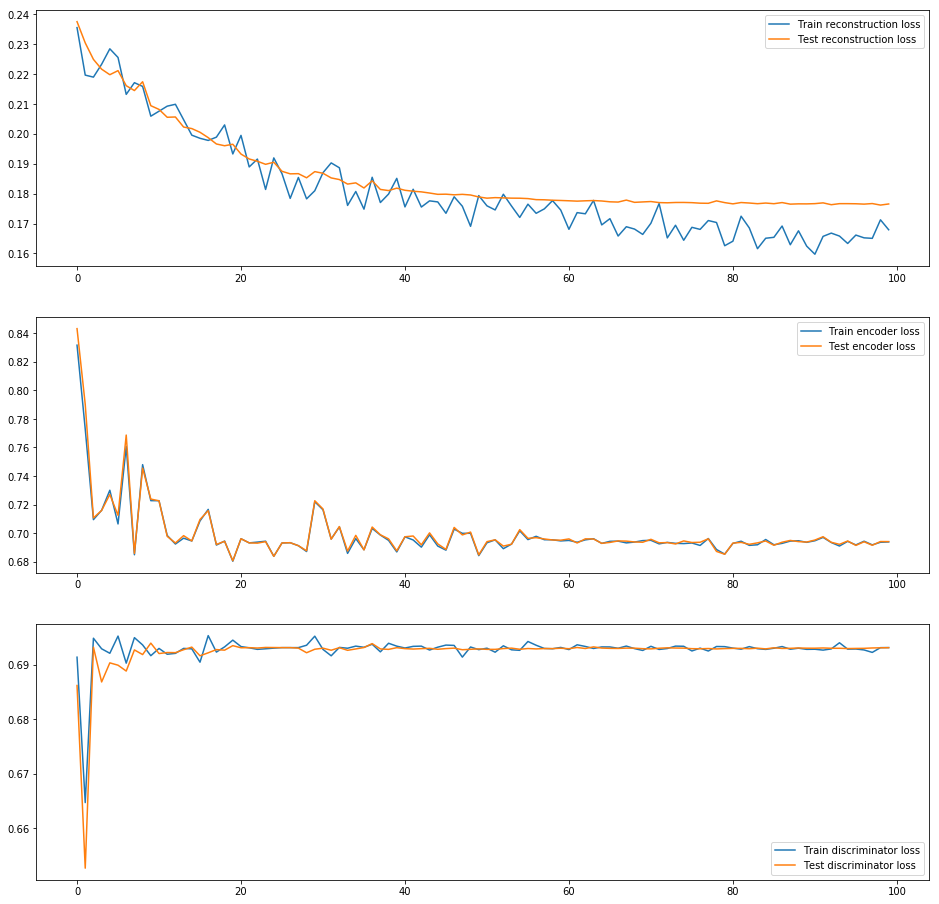

In [12]:
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
plt.plot(train_log["AE"], label="Train reconstruction loss")
plt.plot(test_log["AE"], label="Test reconstruction loss")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(train_log["E"], label="Train encoder loss")
plt.plot(test_log["E"], label="Test encoder loss")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(train_log["DC"], label="Train discriminator loss")
plt.plot(test_log["DC"], label="Test discriminator loss")
plt.legend()
plt.show()

Вывод сгенерированных автокодировщиком изображений по входным данным и по сэмплу нормального распределения.

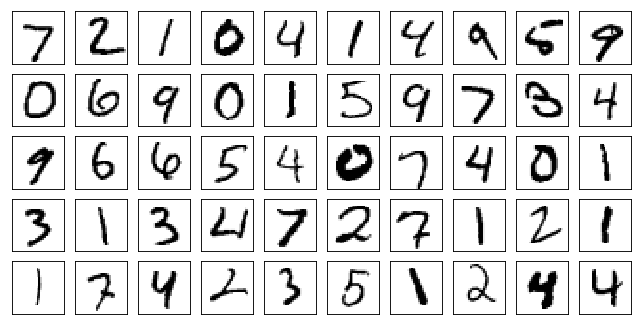

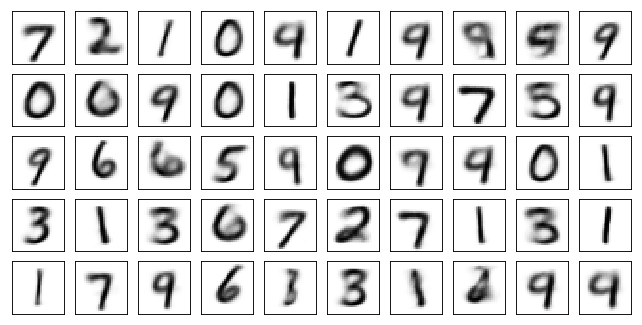

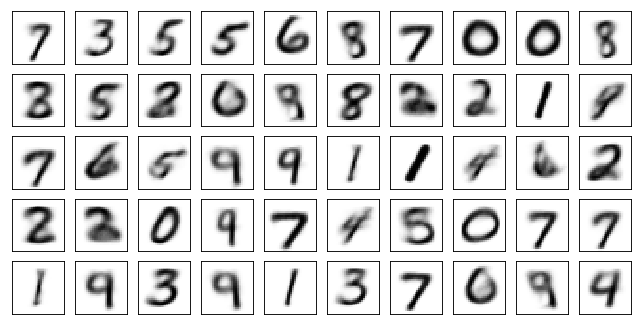

In [13]:
data, _ = next(iter(test_loader))
data = data[:50].to(device)
output = D(E(data))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = D(distribution.sample((param_batch_size, ))[:50].to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(dec_to_plot, (5, 10))

Отрисовка места некоторых цифр в латентном пространстве.

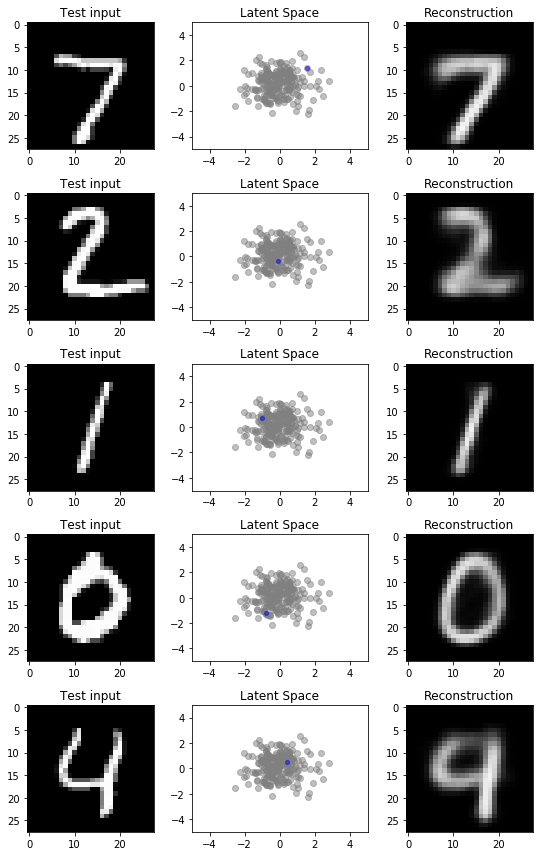

In [14]:
data, _ = next(iter(test_loader))
data = data.to(device)
z = E(data)
output = D(z)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(data[i].cpu().reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Test input")
        
    plt.subplot(5, 3, 3*i + 2)
    plt.scatter(z.cpu().detach()[:,0],z.cpu().detach()[:,1], c='gray', alpha=0.5)
    #plt.scatter(m.cpu().detach()[i,0],m.cpu().detach()[i,1], c='green', s=64, alpha=0.5)
    plt.scatter(z.cpu().detach()[i,0],z.cpu().detach()[i,1], c='blue', s=16, alpha=0.5)
       
    plt.xlim((-5,5))
    plt.ylim((-5,5))
    plt.title("Latent Space")
        
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(output.cpu().detach()[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Reconstruction")
        
    plt.tight_layout()

Карта скрытого пространства.

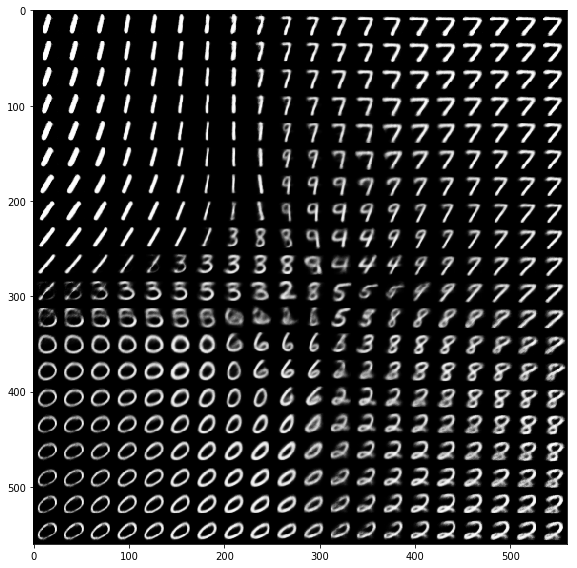

In [15]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        d = np.zeros([1,param_ld_size],dtype='float32')
        z_mu = np.array([[xi, yi]])
        d[0,:2] = z_mu        
        x_mean = D(torch.Tensor(d).to(device))
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean.cpu().detach()[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()